# Python: Conditional Average Treatment Effects (CATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators).

## One-dimensional Example

We start with an one-dimensional effect and create our training data. In this example the true effect depends only the first covariate $X_1$ and takes the following form

$$
g(X) = \exp(2X_0) + 3\sin(4X_0).
$$

The generated dictionary also contains a callable with key `treatment_effect` to calculate the true treatment effect for new observations.

In [2]:
data_dict = make_heterogeneous_data(
    n_obs=2000,
    p=10,
    support_size=5,
    n_x=1,
    binary_treatment=True,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,6.708383,1.0,0.639988,0.885665,0.742485,0.698780,0.842124,0.127368,0.574826,0.399619,0.950982,0.674295
1,7.308917,1.0,0.679626,0.919538,0.002009,0.634498,0.587682,0.036961,0.457041,0.728375,0.529670,0.002297
2,2.088032,0.0,0.318602,0.365588,0.429477,0.916541,0.082547,0.703588,0.407846,0.034248,0.747236,0.578367
3,7.077948,1.0,0.744157,0.523000,0.552090,0.352567,0.821838,0.906797,0.091780,0.330467,0.735209,0.245403
4,4.814434,1.0,0.266560,0.554739,0.041761,0.092677,0.251605,0.405535,0.948471,0.281858,0.033234,0.932486


First, define the ``DoubleMLData`` object.

In [3]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

Next, define the learners for the nuisance functions and fit the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html). Remark that linear learners would usually be optimal due to the data generating process.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.05,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.490975  0.042038  106.83152    0.0  4.408583  4.573368


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x": data["X_0"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  1.290703  0.177007   7.291819   4.388884e-13  0.943565  1.637841
1  1.437894  0.297304   4.836446   1.423058e-06  0.854835  2.020953
2  4.311195  0.187671  22.972143  8.417174e-104  3.943144  4.679246
3  4.102718  0.228929  17.921317   1.036984e-66  3.653752  4.551684
4  3.157030  0.230294  13.708693   6.084183e-41  2.705388  3.608672
5  3.808364  0.254633  14.956316   5.138096e-48  3.308991  4.307738


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.060618  2.390078  2.719537
1   2.145456  2.480927  2.816398
2   2.229022  2.571926  2.914830
3   2.312179  2.663075  3.013972
4   2.395631  2.754375  3.113119
..       ...       ...       ...
95  4.399290  4.722856  5.046421
96  4.411248  4.727858  5.044468
97  4.425709  4.735225  5.044740
98  4.441982  4.744956  5.047931
99  4.459209  4.757053  5.054896

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

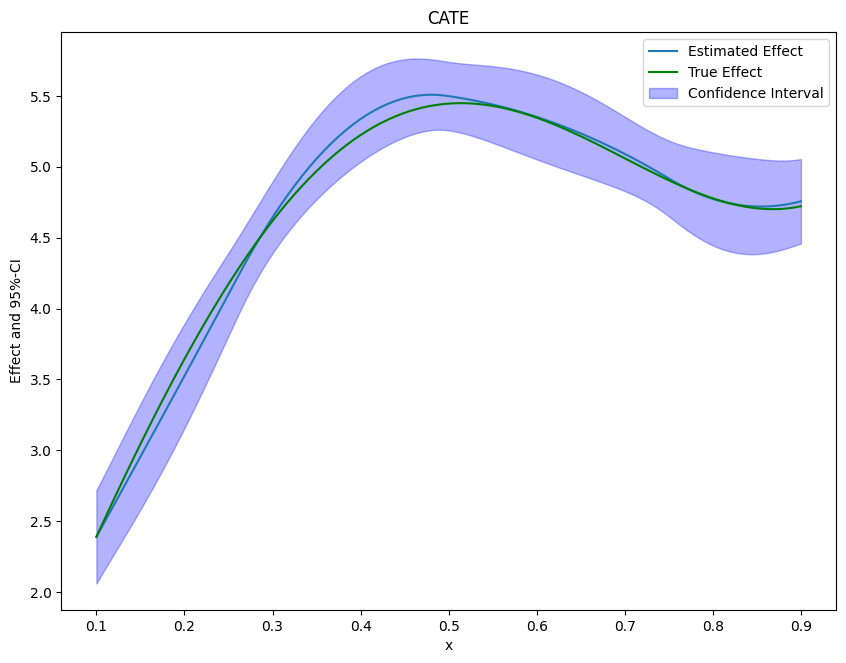

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect(new_data["x"].reshape(-1, 1))
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

If the effect is not one-dimensional, the estimate still corresponds to the projection of the true effect on the basis functions.

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use a similar data generating process but now the effect depends on the first two covariates $X_0$ and $X_1$ and takes the following form
$$
g(X) = \exp(2X_0) + 3\sin(4X_1).
$$

With the argument ``n_x=2`` we can specify set the effect to be two-dimensional.

In [9]:
data_dict = make_heterogeneous_data(
    n_obs=5000,
    p=10,
    support_size=5,
    n_x=2,
    binary_treatment=True,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,6.757749,1.0,0.764626,0.769884,0.817488,0.841155,0.420436,0.867550,0.525937,0.470597,0.718536,0.213818
1,8.143517,1.0,0.789497,0.429466,0.127295,0.119312,0.164907,0.890573,0.990938,0.356974,0.292144,0.218771
2,1.761315,0.0,0.823816,0.209207,0.924090,0.667350,0.897128,0.554010,0.690680,0.619458,0.831195,0.835861
3,5.185085,1.0,0.589793,0.632508,0.921876,0.929866,0.664250,0.007754,0.104411,0.857943,0.084714,0.213519
4,1.235903,0.0,0.230547,0.600235,0.576633,0.289418,0.207611,0.764532,0.935456,0.052806,0.133180,0.642164


As univariate example estimate the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html).

In [10]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.05,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err           t  P>|t|    2.5 %    97.5 %
d  4.416886  0.039402  112.098282    0.0  4.33966  4.494113


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["X_0"], "x_1": data["X_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t          P>|t|    [0.025     0.975]
0   2.534860  0.109945  23.055645  8.317168e-112  2.319319   2.750402
1  -2.730973  0.983888  -2.775695   5.529068e-03 -4.659829  -0.802117
2   2.369287  0.954872   2.481262   1.312477e-02  0.497315   4.241259
3   2.724222  0.814209   3.345849   8.264200e-04  1.128011   4.320434
4   1.707822  0.798117   2.139813   3.241864e-02  0.143158   3.272485
5  -2.374490  0.992819  -2.391665   1.680923e-02 -4.320854  -0.428125
6  -5.896299  1.013852  -5.815742   6.415475e-09 -7.883897  -3.908700
7  -4.778558  0.940546  -5.080623   3.900266e-07 -6.622444  -2.934671
8  -0.233787  0.961123  -0.243243   8.078270e-01 -2.118014   1.650441
9   1.160965  0.984471   1.179278   2.383440e-01 -0.769034   3.090964
10  1.632546  0.869986   1.876520   6.064265e-02 -0.073012   3.338104
11  1.222431  0.864694   1.413715   1.575084e-01 -0.

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.246081  2.038470  2.830859
1     1.299506  2.059702  2.819899
2     1.363617  2.086690  2.809763
3     1.435085  2.118699  2.802314
4     1.510444  2.154999  2.799554
...        ...       ...       ...
9995  3.638872  4.317311  4.995751
9996  3.717783  4.417601  5.117418
9997  3.804472  4.523797  5.243123
9998  3.901674  4.636260  5.370846
9999  4.011191  4.755347  5.499504

[10000 rows x 3 columns]


In [15]:
import plotly.graph_objects as go

grid_array = np.array(list(zip(x_0.ravel(), x_1.ravel())))
true_effect = treatment_effect(grid_array).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()